In [38]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import matplotlib.pyplot  as plt

import seaborn as sns

In [3]:
train_payment = pd.read_csv('./train_payment.csv')
train_activity = pd.read_csv('./train_activity.csv')
train_label = pd.read_csv('./train_label_add.csv')

# 1) 40000명으로 압축해서 군집화 

In [66]:
# 파일 압축 및 합치기
act = train_activity.groupby(['acc_id']).sum().reset_index()
pay = train_payment.groupby(['acc_id']).sum().reset_index()
act_pay = pd.merge(act, pay, on ='acc_id',how='outer').fillna(0)

In [67]:
# 전체 sum
knn_act = act_pay[['acc_id','playtime','solo_exp']]
feature=knn_act[['playtime','solo_exp']]

In [136]:
# create model and prediction
model = KMeans(n_clusters=2,algorithm='auto')

model.fit(feature)

predict = pd.DataFrame(model.predict(feature))

predict.columns=['predict']



In [137]:
r = pd.concat([feature,predict],axis=1)

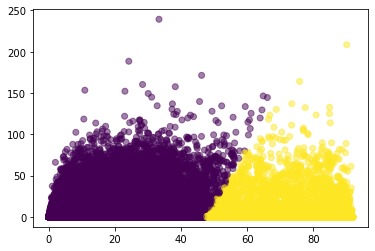

In [138]:
plt.scatter(r['playtime'],r['solo_exp'],c=r['predict'],alpha=0.5)

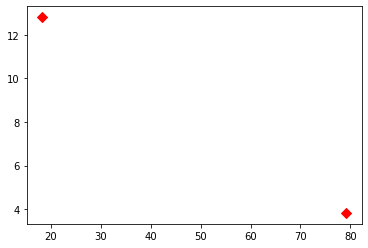

In [139]:
centers = pd.DataFrame(model.cluster_centers_,columns=['playtime','solo_exp'])

center_x = centers['playtime']

center_y = centers['solo_exp']

plt.scatter(center_x,center_y,s=50,marker='D',c='r')

plt.show()

In [140]:
acc = knn_act['acc_id']
r2 = pd.concat([acc, r],axis=1)
r2 = pd.merge(r2, train_label, on ='acc_id').drop('Unnamed: 0',axis=1)

<BarContainer object of 2 artists>

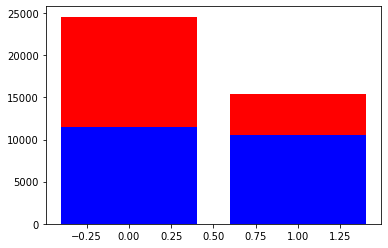

In [141]:
a=r2[(r2['predict']==0) & (r2['secession']==0)]['acc_id'].count()
b=r2[(r2['predict']==0) & (r2['secession']==1)]['acc_id'].count()
c=r2[(r2['predict']==1) & (r2['secession']==0)]['acc_id'].count()
d=r2[(r2['predict']==1) & (r2['secession']==1)]['acc_id'].count()
#e=r2[(r2['predict']==2) & (r2['secession']==0)]['acc_id'].count()
#f=r2[(r2['predict']==2) & (r2['secession']==1)]['acc_id'].count()

good = [a,c]
bad = [b,d]
X = np.arange(len(good))
plt.bar(X, good, color='b')
plt.bar(X, bad, color='r', bottom=good)


In [142]:
cor = r2.corr()
cor['predict'].sort_values(ascending=False)

predict          1.000000
playtime         0.914503
survival_time    0.198165
acc_id          -0.000997
total_spent     -0.022077
amount_spent    -0.055470
secession       -0.205629
solo_exp        -0.247324
Name: predict, dtype: float64

# 2) day별로 군집화 

In [143]:
# 1단계: 필요한 컬럼 불러오기 및 char 압축
# 2단계: 접속하지 않은 날은 0으로 하는 컬럼 만들기
# 3단계: 일별로 군집화 실시
# 4단계: 시계열 군집화 실시

In [144]:
# 1단계: 필요한 컬럼 불러오기 및 char 압축
knn_act = train_activity[['day','acc_id','char_id','playtime','solo_exp']]
knn_act = knn_act.groupby(['day','acc_id']).sum().reset_index().drop('char_id',axis=1)

In [145]:
# 2단계: 접속하지 않은 날은 0으로 하는 컬럼 만들기

# acc_id 40000개와 28일인 데이터프레임 만들기
knn=np.zeros(shape=(40000*28,2))
acc_id = train_label['acc_id']
acc_id = acc_id.values

for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        knn[n][0] = acc[i]
        knn[n][1] = j+1
knn_df = DataFrame(knn, columns=['acc_id','day'])

# 만든 데이터프레임에 훈련데이터 merge
knn_df = pd.merge(knn_df, knn_act, on=['acc_id','day'], how='outer')
#.fillna(0)

In [149]:
knn_act.shape

(949358, 4)

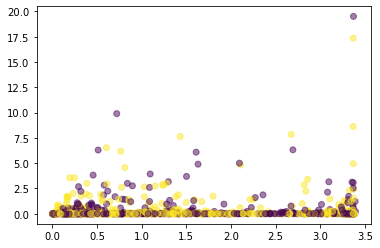

In [126]:
# 3단계: 일별로 군집화 실시
feature = knn_df[(knn_df['day']==28)][['playtime','solo_exp']]

# create model and prediction
model = KMeans(n_clusters=2,algorithm='auto')

model.fit(feature)

predict = pd.DataFrame(model.predict(feature))

predict.columns=['predict']

r = pd.concat([feature,predict],axis=1)
plt.scatter(r['playtime'],r['solo_exp'],c=r['predict'],alpha=0.5)

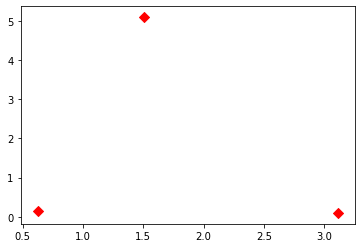

In [125]:
centers = pd.DataFrame(model.cluster_centers_,columns=['playtime','solo_exp'])

center_x = centers['playtime']

center_y = centers['solo_exp']

plt.scatter(center_x,center_y,s=50,marker='D',c='r')

plt.show()

In [121]:
acc = knn_act['acc_id']
r2 = pd.concat([acc, r],axis=1)
r2 = pd.merge(r2, train_label, on ='acc_id').drop('Unnamed: 0',axis=1)

<BarContainer object of 2 artists>

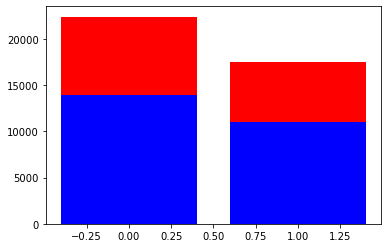

In [122]:
a=r2[(r2['predict']==0) & (r2['secession']==0)]['acc_id'].count()
b=r2[(r2['predict']==0) & (r2['secession']==1)]['acc_id'].count()
c=r2[(r2['predict']==1) & (r2['secession']==0)]['acc_id'].count()
d=r2[(r2['predict']==1) & (r2['secession']==1)]['acc_id'].count()
#e=r2[(r2['predict']==2) & (r2['secession']==0)]['acc_id'].count()
#f=r2[(r2['predict']==2) & (r2['secession']==1)]['acc_id'].count()

good = [a,c]
bad = [b,d]
X = np.arange(len(good))
plt.bar(X, good, color='b')
plt.bar(X, bad, color='r', bottom=good)

# 2. 두번째 시도: 접속 패턴을 군집화 하기 

### 2-1) 접속패턴 군집화를 위한 데이터 만들기

In [271]:

# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0


stop_count_df = stop_count_df.drop('playtime',axis=1)

In [272]:
stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1

stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])

In [273]:
stop_count_df.head()

,acc_id,day,login,stop
0,2.0,1.0,1.0,0.0
1,2.0,2.0,1.0,0.0
2,2.0,3.0,1.0,0.0
3,2.0,4.0,1.0,0.0
4,2.0,5.0,1.0,0.0


In [274]:
# 접속패턴 데이터셋을 만드는 데 필요한 acc_id와 login 컬럼만 stop_count_df에서 뽑아옵니다. 
day_pattern_df = stop_count_df[['acc_id','login']]

In [275]:
# 행은 40000유저 * 28일이므로 1120000입니다.
day_pattern_df.shape

(1120000, 2)

In [276]:
# 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
day_pattern_np = day_pattern_df.values

In [277]:
# 열은 'acc_id + 28일' 이므로 29입니다.
pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
        # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        pattern_np[i][0] = day_pattern_np[i*28][0]
        # 각 acc_id마다 행으로 28 단위로 입력된 login을 열 방향으로 입력합니다. 
        # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        pattern_np[i][j+1] = day_pattern_np[28*i+j][1]

In [278]:
# 머리 아파서 컬럼명은 수작업으로 입력했습니다. 
day_pattern_df = DataFrame(pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])

In [279]:
# 완성입니다. 
day_pattern_df.head()

,acc_id,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,20.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 2-1) 접속패턴 군집화 실시

In [291]:
login = day_pattern_df.drop(['acc_id'],axis=1)

In [310]:
# create model and prediction
model = KMeans(n_clusters=2,algorithm='auto')

model.fit(login)

predict = pd.DataFrame(model.predict(login))

predict.columns=['predict']

In [311]:
r = pd.concat([login,predict],axis=1)

(array([ 6740.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 33260.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

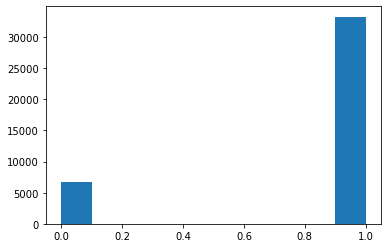

In [312]:
# 군집 2인 경우
# 히스토그램
plt.hist(r['predict'])

(array([31455.,     0.,     0.,     0.,     0.,  4026.,     0.,     0.,
            0.,  4519.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

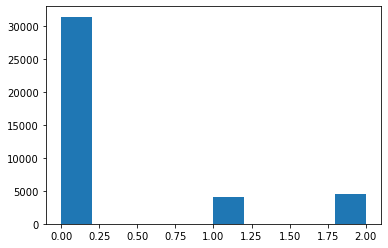

In [301]:
# 군집 2인 경우
# 히스토그램
plt.hist(r['predict'])

In [313]:
login_cluster = pd.concat([day_pattern_df['acc_id'],r],axis=1)

In [314]:
log_pattern0 = login_cluster[login_cluster['predict']==0]

In [315]:
log_pattern1 = login_cluster[login_cluster['predict']==1]

In [308]:
log_pattern2 = login_cluster[login_cluster['predict']==2]

### 군집 2인 경우 빈도 그래프 ( 그래프 제목은 day, x축은 이탈 여부, y축은 빈도)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002066F1A6080>,
      dtype=object)

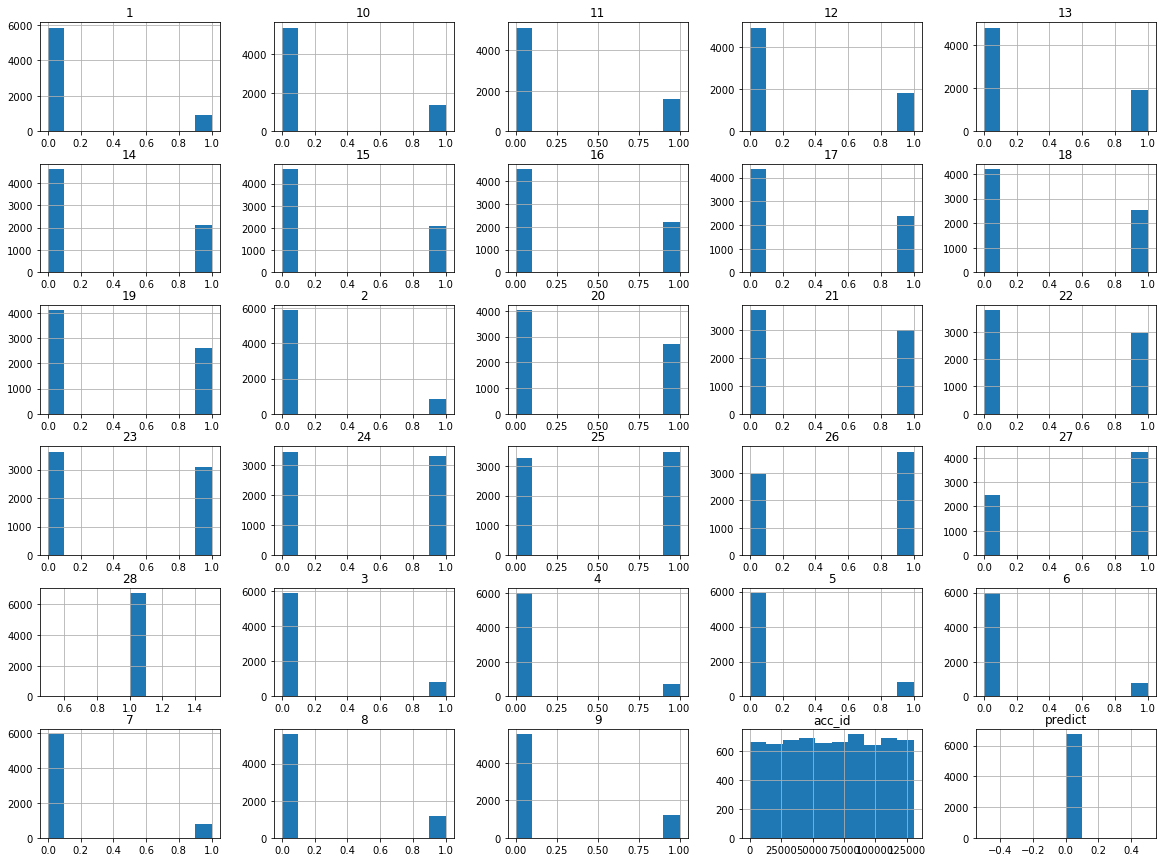

In [316]:
# 군집 2인 경우
# predict=0 
#25일부터 접속이 비접속보다 많아지는  찻번째 그룹입니다.  

log_pattern0.hist(figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000204BCCD2400>,
      dtype=object)

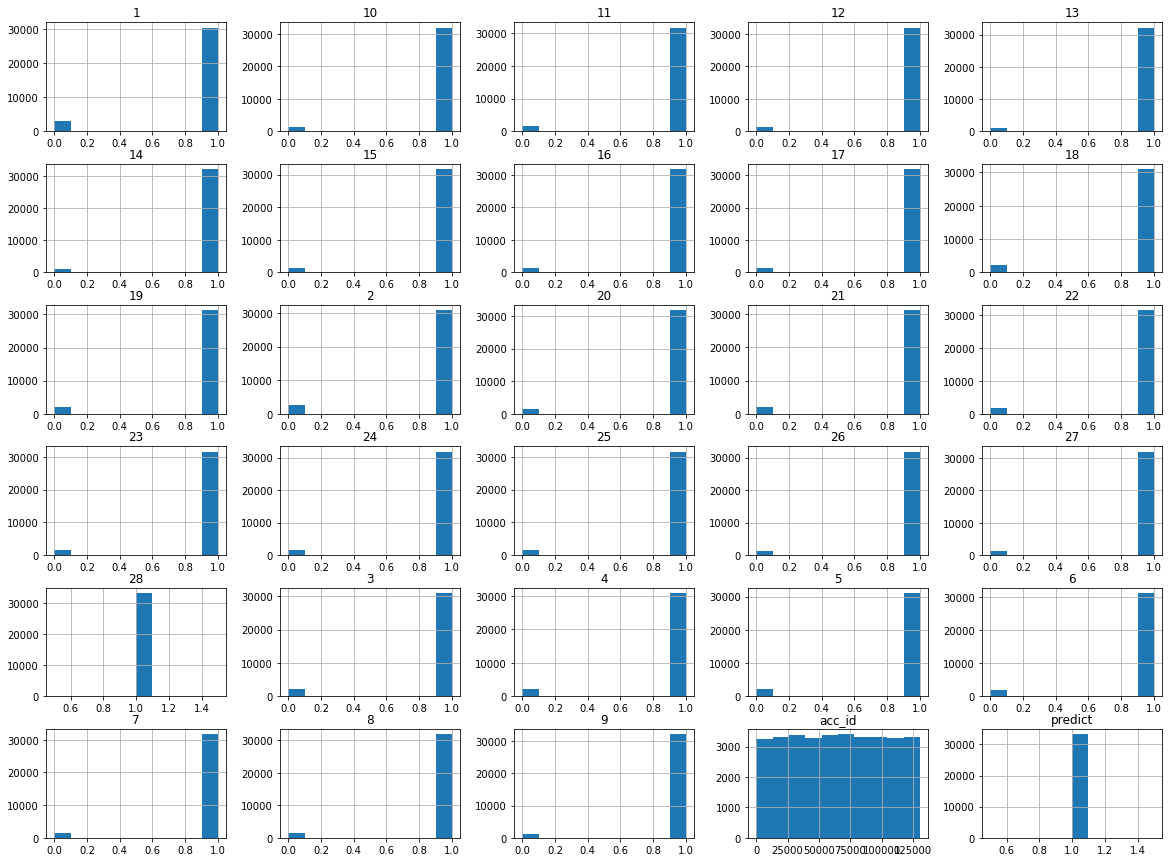

In [317]:
# 군집 2인 경우
# predict=1
#28일 내내 접속이 압도적인 찻번째 그룹입니다.  (약 33000명으로 가장 많은 그룹)
log_pattern1.hist(figsize=(20,15))

### 군집 3인 경우 빈도 그래프 ( 그래프 제목은 day, x축은 이탈 여부, y축은 빈도)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002063C773320>,
      dtype=object)

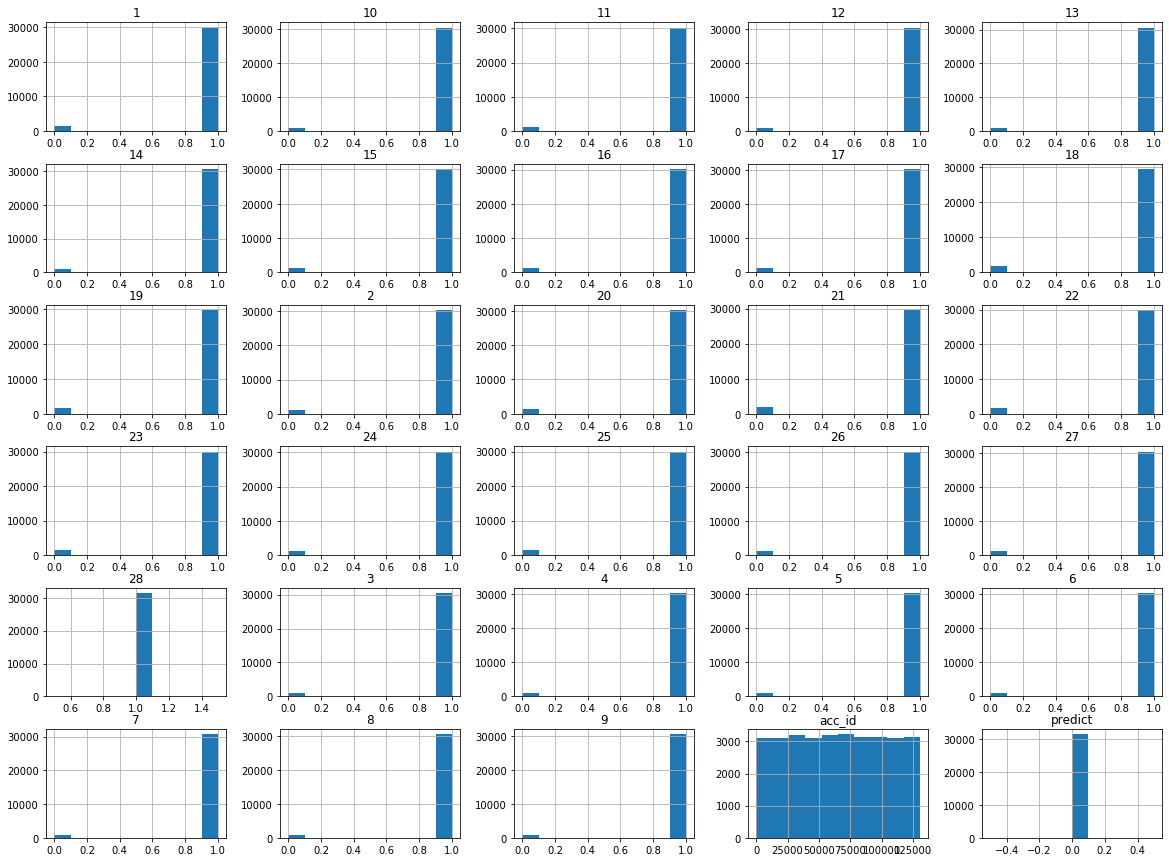

In [305]:
# 군집 3인 경우
# predict=0 
#28일 내내 접속이 압도적인 찻번째 그룹입니다.  (약 31000명으로 가장 많은 그룹)

log_pattern0.hist(figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020654A101D0>,
      dtype=object)

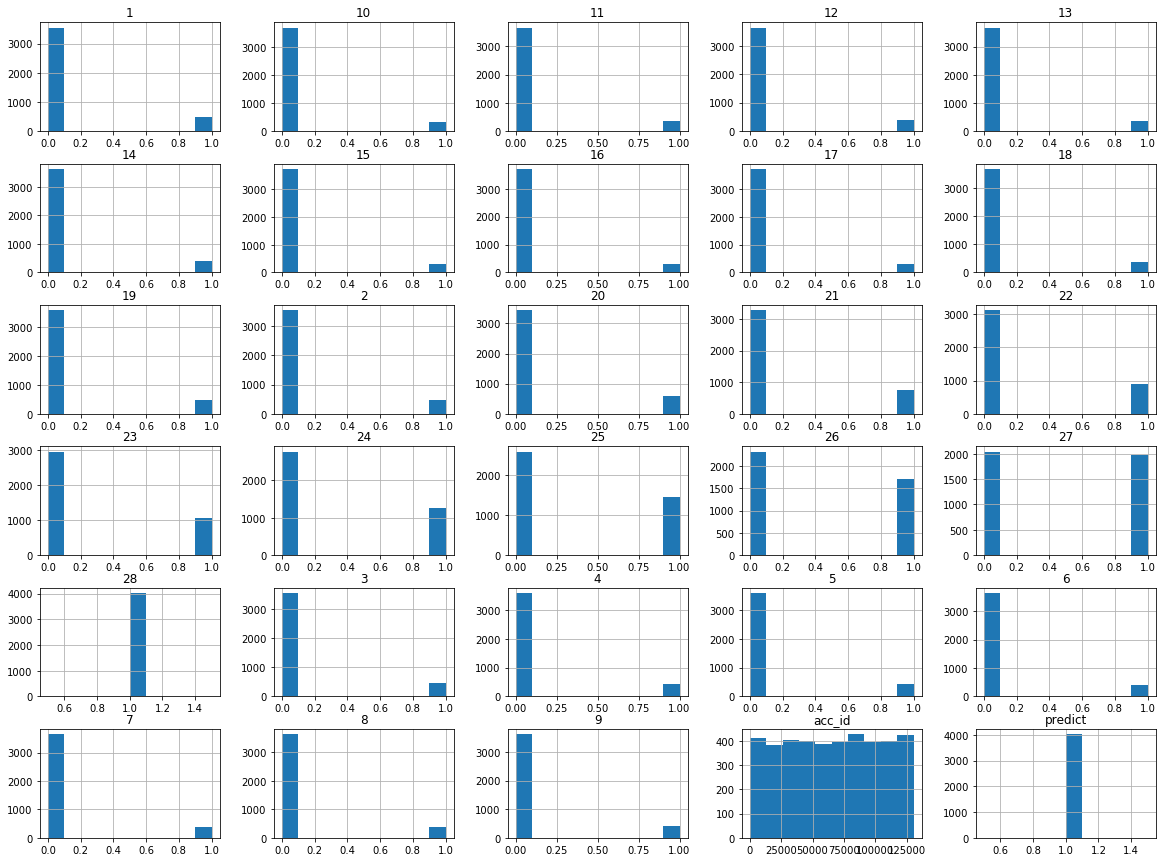

In [306]:
# 군집 3인 경우
# predict=1
# 27일까지 비접속이 많은 2번째 그룹입니다.
log_pattern1.hist(figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020667421780>,
      dtype=object)

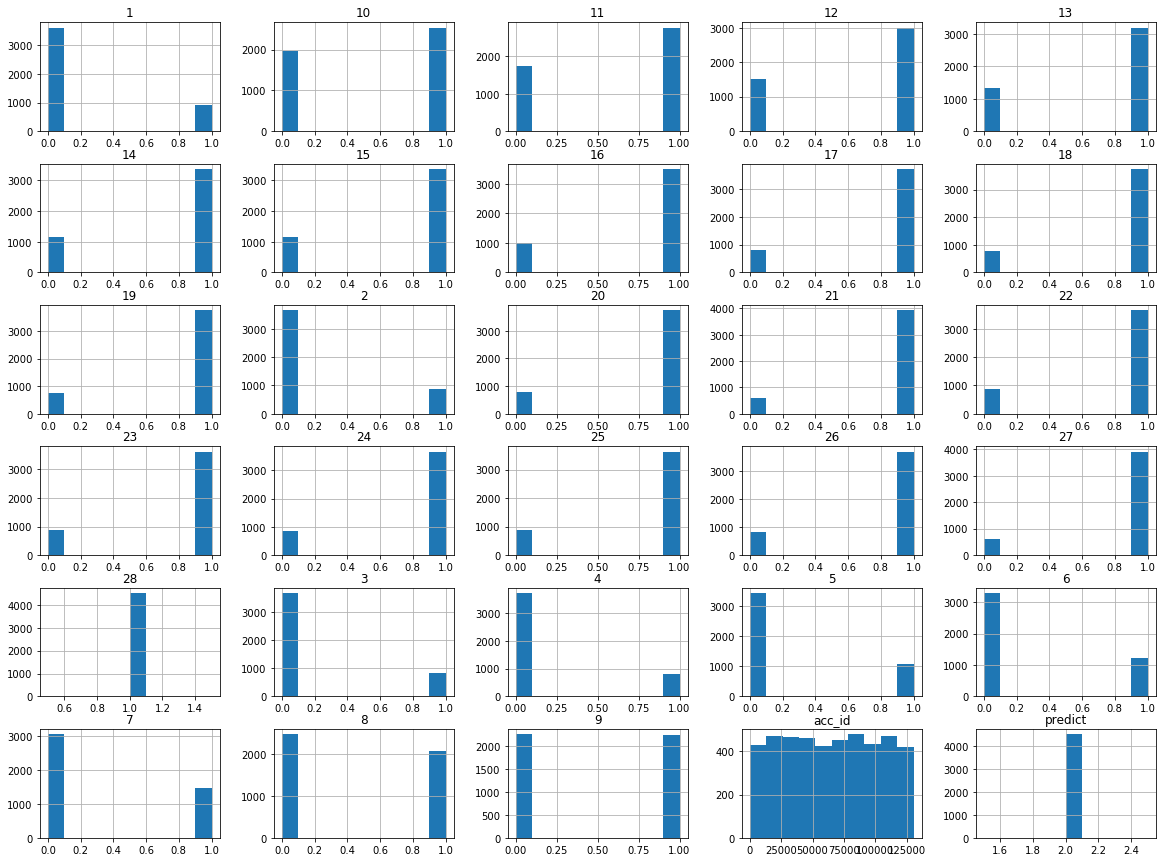

In [309]:
# predict=2
# 10일부터 접속이 비접속보다 많아지는 첫번째 그룹입니다.

log_pattern2.hist(figsize=(20,15))

In [323]:
acc = day_pattern_df['acc_id']
r_acc = pd.concat([acc, r],axis=1)
r_label = pd.merge(r_acc, train_label, on ='acc_id')
#.drop('Unnamed: 0',axis=1)

<BarContainer object of 3 artists>

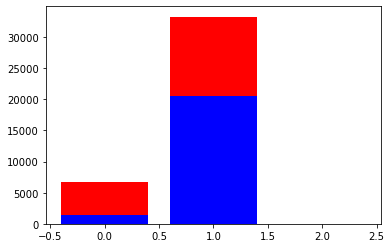

In [324]:
# 이탈 여부와 군집을 비교해보았습니다. 
a=r_label[(r_label['predict']==0) & (r_label['secession']==0)]['acc_id'].count()
b=r_label[(r_label['predict']==0) & (r_label['secession']==1)]['acc_id'].count()
c=r_label[(r_label['predict']==1) & (r_label['secession']==0)]['acc_id'].count()
d=r_label[(r_label['predict']==1) & (r_label['secession']==1)]['acc_id'].count()
e=r_label[(r_label['predict']==2) & (r_label['secession']==0)]['acc_id'].count()
f=r_label[(r_label['predict']==2) & (r_label['secession']==1)]['acc_id'].count()

good = [a,c,e]
bad = [b,d,f]

X = np.arange(len(good))
plt.bar(X, good, color='b')
plt.bar(X, bad, color='r', bottom=good)

In [325]:
r_label.columns

Index(['acc_id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', 'predict', 'survival_time', 'amount_spent',
       'secession', 'total_spent'],
      dtype='object')

In [326]:
# 군집 2인 경우
# 생존기간과 상관관계가 높은 편입니다.
# 상관관계가 높다고 모델에 꼭 중요하다고 볼 수는 없지만 긍정적인 신호입니다. 
r_label_cor = r_label[['predict', 'survival_time', 'amount_spent',
       'secession', 'total_spent']].corr()
r_label_cor['predict']

predict          1.000000
survival_time    0.373768
amount_spent    -0.080199
secession       -0.299957
total_spent      0.102333
Name: predict, dtype: float64

In [262]:
# 군집 3인 경우
# 생존기간과 상관관계가 높은 편입니다.
# 상관관계가 높다고 모델에 꼭 중요하다고 볼 수는 없지만 긍정적인 신호입니다. 
r_label_cor = r_label[['predict', 'survival_time', 'amount_spent',
       'secession', 'total_spent']].corr()
r_label_cor['predict']

predict          1.000000
survival_time    0.292292
amount_spent    -0.055058
secession       -0.263407
total_spent      0.080231
Name: predict, dtype: float64

### 2-2-1) 2개 군집 모델 적용

In [327]:
# 실제 모델에 적용해서 비교하기
# 2군집
r_label2 = r_label
r_label2 = r_label2

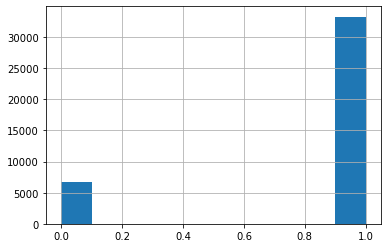

In [328]:
r_label2['predict'].hist()

In [241]:
r_train = r_label2.drop(['survival_time', 'amount_spent',
       'secession', 'total_spent'],axis=1)

In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(r_train, r_label2['survival_time'], test_size=0.3, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape,y_test.shape

((28000, 30), (12000, 30), (28000,), (12000,))

In [245]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42,criterion = 'entropy')
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))
#print(rnd_clf.__class__.__name__, f1_score(y_test, y_pred)) 

RandomForestClassifier 0.41341666666666665


### 2-2-2) 3개 군집 모델 적용 

In [263]:
# 실제 모델에 적용해서 비교하기
# 3군집
r_label3 = r_label
r_label3 = r_label3

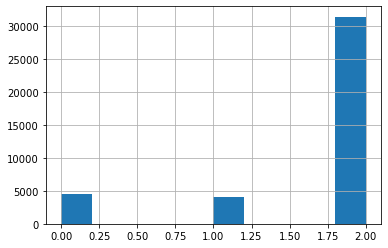

In [264]:
r_label3['predict'].hist()

In [265]:
r_train = r_label3.drop(['survival_time', 'amount_spent',
       'secession', 'total_spent'],axis=1)

In [266]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(r_train, r_label3['survival_time'], test_size=0.3, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape,y_test.shape

((28000, 30), (12000, 30), (28000,), (12000,))

In [267]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42,criterion = 'entropy')
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))
#print(rnd_clf.__class__.__name__, f1_score(y_test, y_pred)) 

RandomForestClassifier 0.41325


# 결론

1) 활동시간과 경험치는 군집화에 의미가 없어보인다. 0에 붙어있는 값들이 너무 많다. 

2) 3개 이상의 변수를 추가할 수 있으나 소모시간이 너무 많을 것으로 예상되어 포기한다.

3) 그래도 전투 유형으로 나누는 등의 군집화는 가능성이 있다.

3) 접속패턴은 2개 군집으로 구분하는 것이 상관관계도 높고, 랜덤포레스트 결과도 미약하나마(약 0.00017) 더 높다.